<img src="img/keraslogo.jpg"></img>

## Содержание

- [ Модели Keras ](#1)
    - [ Создание Sequential модели ](#2)
    - [ Создание модели функциональном стиле ](#3)
    - [ Создание модели комбинированном стиле ](#4)
    - [ Создание модели из существующих моделей ](#5)
    - [ Сохранение моделей ](#6)
    - [ Загрузка моделей ](#7)
- [ Слои в Keras](#8)
    - [ Веса ](#9)
    - [ Функции активации ](#10)
    - [ Полносвязный слой ](#11)
    - [ Flatten слой ](#12)
    - [ Lambda слой ](#13)
- [ Компиляция модели](#14)
- [ Обучение модели](#15)
    - [ Импорт датасета ](#16)
    - [ Создание модели ](#17)
    - [ Компиляция модели ](#18)
    - [ Настройка сценария обучения модели ](#19)
    - [ Обучение модели ](#20)
    - [ Визуализация обучения ](#21)
    - [ Оценка модели ](#22)
    - [ Инференс модели ](#23)
- [ Кастомизация цикла обучения модели](#24)
- [ ImageDataGenerator](#25)
    - [ Скачивание и распаковка изображений ](#26)
    - [ Создание ImageDataGenerator ](#27)
        - [ Аугментация с ImageDataGenerator ](#28)
        - [ Модель для аугментации ](#29)
    - [ Обучение моддели с ImageDataGenerator ](#30)


    

___
## <center><a style="color:red" id=1>Модели Keras</a>
___

In [ ]:
# !pip install tensorflow[and-cuda]==2.17
# !pip install --upgrade tf-models-official

In [33]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model, Sequential, layers
from tensorflow.keras.applications import Xception, EfficientNetB0
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TerminateOnNaN, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import wget
import os
import zipfile2
import albumentations as A
import matplotlib.pyplot as plt

___
### <a id=2>Создание Sequential модели</a>

In [6]:
model = Sequential([
    layers.Dense(100, 'relu',input_shape=(50,) ),
    layers.Dense(100, 'relu'),
    layers.Dense(10, 'softmax')
])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 100)            │         5,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,210 (63.32 KB)

 Trainable params: 16,210 (63.32 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
batch_size = 64

input_batch = np.zeros((batch_size, 50))
output = model(input_batch).numpy() 

output.shape

(64, 10)

- training=True: режим обучения модели
- Dropout работает только в режиме инференса

In [39]:
model = Sequential([
  layers.Dropout(0.99)
])
 
print(model(np.ones((1, 5))).numpy())
print(model(np.ones((1, 5)), training=True).numpy())
print(model(np.ones((1, 5)), training=False).numpy())

[[1. 1. 1. 1. 1.]]
[[0. 0. 0. 0. 0.]]
[[1. 1. 1. 1. 1.]]


___
### <a id=3>Создание модели функциональном стиле</a>

![model scheme.png](<attachment:model scheme.png>)
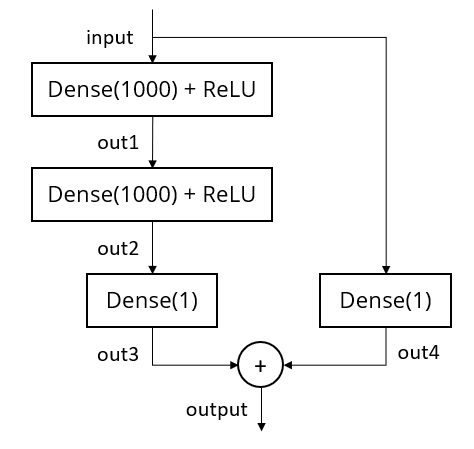

In [32]:
input = keras.Input(shape=(50,))
out1 = layers.Dense(1000, 'relu')(input)
out2 = layers.Dense(1000, 'relu')(out1)

out3 = layers.Dense(1)(out2)
out4 = layers.Dense(1)(input)
output = out3 + out4

model_1 = Model(inputs=input, outputs=output)

model_output = model_1(input_batch).numpy()
model_output.shape

(64, 1)

- Модель с двумя выходами

In [38]:
model_2 = Model(inputs=input, outputs=[output, out3])

model_output = model_2(input_batch)
model_output[0].shape, model_output[1].shape

(TensorShape([64, 1]), TensorShape([64, 1]))

___
### <a id=4>Создание модели комбинированном стиле</a>

![model scheme.png](<attachment:model scheme.png>)
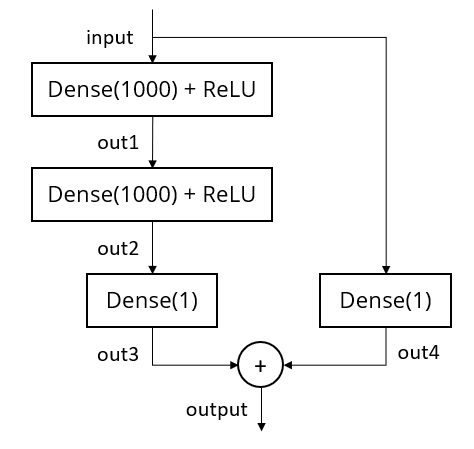

In [41]:
input = keras.Input(shape=(50,))
branch1 = Sequential([
    layers.Dense(1000, 'relu'),
    layers.Dense(1000, 'relu'),
    layers.Dense(1)
])
branch2 = layers.Dense(1)
output = branch1(input) + branch2(input)
model = Model(inputs=input, outputs=output)

model_output = model_1(input_batch).numpy()
model_output.shape

(64, 1)

___
### <a id=5>Создание модели из существующих моделей</a>

- Существующая модель - слой новой модели

In [57]:
model = Sequential([
  Xception(include_top=False, input_shape=(150, 150, 3)),
  layers.GlobalMaxPool2D(),
  layers.Dropout(0.5),
  layers.Dense(10)
])

print(len(model.layers)) #4
print(len(model.layers[0].layers)) #132

4
132


- Слои существующей модели - слои новой модели

In [52]:
base_model = Xception(include_top=False, input_shape=(150, 150, 3))
output = layers.GlobalMaxPool2D()(base_model.output)
output = layers.Dropout(0.5)(output)
output = layers.Dense(10)(output)
model = Model(inputs=base_model.input, outputs=output)

print(len(model.layers)) #4

135


___

- Выход из произвольного слоя модели

In [96]:
model = Sequential([
  layers.InputLayer((400,)),
  layers.Dense(300),
  layers.Dense(20),
  layers.Dense(1),
])

In [87]:
input_data = np.zeros((64, 400))
l1, l2, l3 = model.layers
layer2_output = l2(l1(input_data)).numpy()
layer1_output = l3(l2(l1(input_data))).numpy()

layer2_output.shape, layer1_output.shape


((64, 20), (64, 1))

___
### <a id=6>Сохранение моделей</a>

In [103]:
MODEL_PATH = 'data/model.keras'

model.save(MODEL_PATH) #сохранение

___
### <a id=7>Загрузка моделей</a>

In [107]:
model = keras.models.load_model(MODEL_PATH) #загрузка

model.count_params()

126341

___
## <center><a style="color:red" id=8>Слои в Keras</a>
___

___
### <a id=9>Веса</a>

In [119]:
model.layers

[<Dense name=dense_98, built=True>,
 <Dense name=dense_99, built=True>,
 <Dense name=dense_100, built=True>]

- get_weights: вернуть веса модели

In [120]:
layer = model.layers[2]
W, b = layer.get_weights()

print(W.shape, b.shape)

(20, 1) (1,)


- set_weights: установка весов (обнуление)

In [121]:
layer.set_weights((W, np.zeros_like(b)))


При создании слоя не в составе модели веса слоя не будут созданы.

In [126]:
layer = layers.Dense(100)
print([x.shape for x in layer.get_weights()])


[]


- build: создание весов для слоя

In [127]:
layer.build((20,)) 
print([x.shape for x in layer.get_weights()])

[(20, 100), (100,)]


- trainable: заморозка/включение слоев

In [183]:
model = Sequential([
    layers.Dense(100, 'relu'),
    layers.Dense(10),
])

model.layers[0].trainable, model.layers[1].trainable

(True, True)

In [184]:
model = Sequential([
    layers.Dense(100, 'relu'),
    layers.Dense(10),
])

model.trainable = False
model.layers[0].trainable, model.layers[1].trainable

(False, False)

In [185]:
model = Sequential([
    layers.Dense(100, 'relu'),
    layers.Dense(10),
])

model.layers[0].trainable = False
model.layers[0].trainable, model.layers[1].trainable

(False, True)

___
### <a id=10>Функции активации</a>

- Функция активации - слой

In [138]:
model = Sequential([
    layers.Dense(100),
    layers.ReLU(),
])

- Функция активации - параметр слоя

In [139]:
model = Sequential([
    layers.Dense(100, activation='relu'),
])

- Функция активации - кастомная функция

In [141]:
custom_func = lambda x: tf.math.sin(x) + x

model = Sequential([
    layers.Dense(100, activation=custom_func),
])

___
### <a id=11>Полносвязный слой</a>

- use_bias: использование смещения
- kernel_initializer: способ инициализации весов
- kernel_regularizer: применение регуляризации к весам
- bias_regularizer: применение регуляризации к смещениям
- activity_regularizer: применение регуляризации к выходным значениям слоя
- kernel_constraint: применение ограничений на значения весов
- bias_constraint: применение ограничений на значения смещений

In [149]:
tf.random.set_seed(0)


L = layers.Dense(units=100,
                use_bias=True,
                kernel_initializer="glorot_uniform"б
                kernel_regularizer=None,
                bias_regularizer=None,
                activity_regularizer=None,
                kernel_constraint=None,
                bias_constraint=None)

___
### <a id=12>Flatten слой</a>

Вытягивает многомерный тензор в вектор

In [161]:
model = Sequential([
    layers.Dense(20, activation=custom_func, input_shape=(100,100)),
])

model.summary()

Model: "sequential_44"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_132 (Dense)               │ (None, 100, 20)        │         2,020 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,020 (7.89 KB)

 Trainable params: 2,020 (7.89 KB)

 Non-trainable params: 0 (0.00 B)

In [166]:
model = Sequential([
    layers.Dense(20, activation=custom_func, input_shape=(100,100)),
    layers.Flatten()
])

model.summary()

Model: "sequential_49"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_137 (Dense)               │ (None, 100, 20)        │         2,020 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 2000)           │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,020 (7.89 KB)

 Trainable params: 2,020 (7.89 KB)

 Non-trainable params: 0 (0.00 B)

___
### <a id=13>Lambda слой</a>

Выполняет функцию над входными данными

In [168]:
layers.Lambda(lambda x: x/255)

model = Sequential([
    layers.Lambda(lambda x: x/255),
    layers.Dense(20, activation=custom_func, input_shape=(100,100)),
])

___
## <center><a style="color:red" id=14>Компиляция модели</a>
___

In [189]:
model = Sequential([
    layers.InputLayer((100,)),
    layers.Dense(500, 'relu'),
    layers.Dense(10, 'softmax')
])


- from_logits: вероятности выходного слоя буду расчитаны в loss-функции - следует убрать функцию активации на выходном слое

In [203]:
scheduler = ExponentialDecay(initial_learning_rate=1e-3, decay_steps=1000, decay_rate=0.9)
optimizer = tf.keras.optimizers.Adam(scheduler)

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = ['accuracy']

model.compile(optimizer=optimizer,
            loss=loss,
            metrics=metrics)

___
## <center><a style="color:red" id=15>Обучение модели</a>
___

___
### <a id=16>Импорт датасета</a>

In [17]:
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()
X_train = X_train.reshape(-1, 28*28) / 255
X_test = X_test.reshape(-1, 28*28) / 255

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((60000, 784), (60000,), (10000, 784), (10000,))

___
### <a id=17>Создание модели</a>

In [18]:
model = Sequential([
  layers.InputLayer((28*28,)),
  layers.Dense(500, 'relu'),
  layers.Dense(500, 'relu'),
  layers.Dense(10)
])

___
### <a id=18>Компиляция модели</a>

In [19]:
scheduler = ExponentialDecay(initial_learning_rate=1e-3, decay_steps=1000, decay_rate=0.9)
optimizer = tf.keras.optimizers.Adam(scheduler)

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = ['accuracy']

model.compile(optimizer=optimizer,
            loss=loss,
            metrics=metrics)

___
### <a id=19>Настройка сценария обучения модели</a>

ModelCheckpoint: сохраняет модель в файл best_model.keras (в текущей рабочей директории) в том случае, если значение val_accuracy после текущей эпохи достигло максимума

In [7]:
model_call = ModelCheckpoint('best_model.keras', monitor='val_accuracy',
                verbose=1, mode='max', save_best_only=True)

EarlyStopping: Обучение модели прекращается, если val_loss не падает в течение пяти эпох

In [31]:
EarlyStopping(monitor='val_loss', patience=5)

TerminateOnNaN: Обучение прекращается, если loss стал равным NaN

In [33]:
TerminateOnNaN()

ReduceLROnPlateau: уменьшает learning rate в те моменты, когда начинает наблюдаться стагнация процесса обучения

In [36]:
ReduceLROnPlateau()

Отображает процесс обучения

In [20]:
logs_path = 'logs/'
tensorboard_call = tf.keras.callbacks.TensorBoard(log_dir=logs_path)

___
### <a id=20>Обучение модели</a>

In [21]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [22]:
model.fit(X_train, y_train,
            validation_data=(X_test, y_test),
            epochs=20,
            batch_size=1024,
            callbacks=tensorboard_call
            )

Epoch 1/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.7700 - loss: 0.8578 - val_accuracy: 0.9410 - val_loss: 0.2012
Epoch 2/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9481 - loss: 0.1764 - val_accuracy: 0.9606 - val_loss: 0.1310
Epoch 3/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9669 - loss: 0.1166 - val_accuracy: 0.9696 - val_loss: 0.1025
Epoch 4/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9777 - loss: 0.0782 - val_accuracy: 0.9735 - val_loss: 0.0841
Epoch 5/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9830 - loss: 0.0599 - val_accuracy: 0.9760 - val_loss: 0.0777
Epoch 6/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9879 - loss: 0.0451 - val_accuracy: 0.9764 - val_loss: 0.0730
Epoch 7/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9906 - loss: 0.0340 - val_accuracy: 0.9785 - val_loss: 0.0717
Epoch 8/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9938 - loss: 0.0251 - val_accuracy: 0.9785 - val_loss

___
### <a id=21>Визуализация обучения</a>

In [15]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [23]:
%tensorboard --logdir logs/

Reusing TensorBoard on port 6006 (pid 67275), started 0:01:52 ago. (Use '!kill 67275' to kill it.)

___
### <a id=22>Оценка модели</a>

In [73]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)

test_loss, test_accuracy

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9705 - loss: 0.0963


(0.080596424639225, 0.9753000140190125)

In [82]:
model.history.history

{'accuracy': [0.9869833588600159,
  0.9902499914169312,
  0.9923666715621948,
  0.9947999715805054,
  0.99631667137146],
 'loss': [0.045189715921878815,
  0.03358937054872513,
  0.026801493018865585,
  0.020303193479776382,
  0.015784859657287598],
 'val_accuracy': [0.9785000085830688,
  0.9790999889373779,
  0.9789999723434448,
  0.9807999730110168,
  0.9797999858856201],
 'val_loss': [0.07035103440284729,
  0.06722817569971085,
  0.06950563192367554,
  0.06322577595710754,
  0.06817250698804855]}

___
### <a id=23>Инференс модели</a>

In [74]:
y_predicted = model.predict((X_test, y_test))

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [75]:
y_predicted[0].argmax() == y_test[0]

True

___
## <center><a style="color:red" id=24>Кастомизация цикла обучения модели</a>
___

- Получаем предсказания модели в режиме обучения и рассчитываем loss. Эти операции мы делаем в контексте объекта tf.GradientTape(), чтобы затем получить градиенты.

- У каждой модели есть параметр .trainable_variables, в котором хранится список тензоров, являющихся обучаемыми весами модели. Мы обращаемся к этому параметру.

- Получаем значения градиентов для `тензоров trainable_vars` из объекта tf.GradientTape().

- Передаём веса и градиенты оптимизатору, который обновляет веса, используя градиенты.

- В последних двух строках метода train_step работаем с метриками.

In [108]:
class CustomSequential(Sequential):
  def train_step(self, data):
    x, y = data
    
    with tf.GradientTape() as tape:
        y_pred = self(x, training=True)
        loss = self.compiled_loss(y, y_pred, regularization_losses=self.losses)
        
    trainable_vars = self.trainable_variables
    gradients = tape.gradient(loss, trainable_vars)
    self.optimizer.apply_gradients(zip(gradients, trainable_vars))
    self.compiled_metrics.update_state(y, y_pred)
    return {m.name: m.result() for m in self.metrics}

In [110]:
model = CustomSequential([
  layers.InputLayer((28*28,)),
  layers.Dense(784, 'relu'),
  layers.Dense(784, 'relu'),
  layers.Dense(10, 'softmax')
])

In [115]:
model.compile(loss=['sparse_categorical_crossentropy'],
              optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, validation_data=(X_test, y_test),
          epochs=20, batch_size=1024)

Epoch 1/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.9966 - loss: 0.1000 - val_accuracy: 0.9822 - val_loss: 0.0789
Epoch 2/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9984 - loss: 0.1000 - val_accuracy: 0.9831 - val_loss: 0.0731
Epoch 3/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9988 - loss: 0.1000 - val_accuracy: 0.9800 - val_loss: 0.0828
Epoch 4/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9974 - loss: 0.1000 - val_accuracy: 0.9785 - val_loss: 0.0936
Epoch 5/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9974 - loss: 0.1000 - val_accuracy: 0.9808 - val_loss: 0.0830
Epoch 6/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9976 - loss: 0.1000 - val_accuracy: 0.9834 - val_loss: 0.0807
Epoch 7/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9995 - loss: 0.1000 - val_accuracy: 0.9813 - val_loss: 0.0905
Epoch 8/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9993 - loss: 0.1000 - val_accuracy: 0.9817 - val_loss

___
## <center><a style="color:red" id=25>ImageDataGenerator</a>
___

___
### <a id=26>Скачивание и распаковка изображений</a>

In [15]:
data_path = "data/dataset_beans/"
wget.download("https://storage.googleapis.com/ibeans/train.zip", data_path)
wget.download("https://storage.googleapis.com/ibeans/validation.zip", data_path)
wget.download("https://storage.googleapis.com/ibeans/test.zip", data_path)

train_path = os.path.join(data_path, "train.zip")
test_path = os.path.join(data_path, "test.zip")
val_path = os.path.join(data_path, "validation.zip")

unzip_list = [train_path, test_path, val_path]
for unzip_file in unzip_list:
    with zipfile2.ZipFile(unzip_file) as zip_f:
        zip_f.extractall(data_path)

100% [........................................................................] 17708541 / 17708541

___
### <a id=27>Создание ImageDataGenerator</a>

In [7]:
train_datagen = ImageDataGenerator(
    rescale=1/255,
    horizontal_flip=True,
    # rotation_range=10,
    # shear_range=0.2,
    brightness_range=(0.8, 1.2),
)

train_generator = train_datagen.flow_from_directory(
    os.path.join(data_path, "train"),
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
)

next(train_generator)[0].shape, next(train_generator)[1].shape

Found 1034 images belonging to 3 classes.


((32, 128, 128, 3), (32, 3))

reset: вернуться к началу и перебирать изображения заново

{'angular_leaf_spot': 0, 'bean_rust': 1, 'healthy': 2}


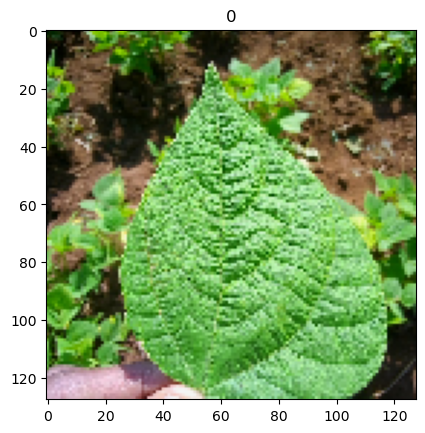

In [8]:
import matplotlib.pyplot as plt

IMAGES_INDEX = 0
CLASS_INDEX = 1
INDEX = 10

print(train_generator.class_indices)
train_generator.reset()
plt.imshow(next(train_generator)[IMAGES_INDEX][INDEX])
plt.title(next(train_generator)[CLASS_INDEX][INDEX].argmax());


___
#### <a id=28>Аугментация с ImageDataGenerator</a>

In [16]:
def augment(image):
    
    # image = image.astype(np.float64)
    
    aug = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomGamma(p=0.3),
    A.VerticalFlip(p=0.5),
])
    return aug(image=image)['image']

datagen_augment = ImageDataGenerator(
    preprocessing_function=augment,
    rescale=1/255,
    
)

train_generator = datagen_augment.flow_from_directory(
    os.path.join(data_path, "train"),
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
)

Found 1034 images belonging to 3 classes.


{'angular_leaf_spot': 0, 'bean_rust': 1, 'healthy': 2}


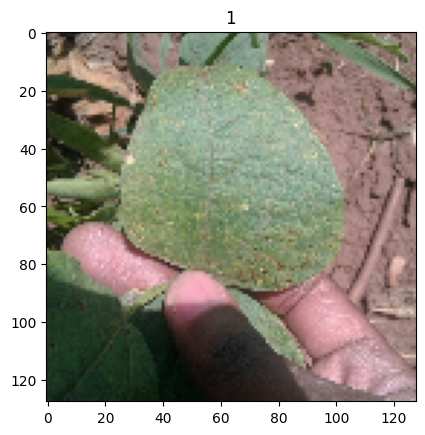

In [19]:
IMAGES_INDEX = 0
CLASS_INDEX = 1
INDEX = 10

print(train_generator.class_indices)
train_generator.reset()
plt.imshow(next(train_generator)[IMAGES_INDEX][INDEX])
plt.title(next(train_generator)[CLASS_INDEX][INDEX].argmax());

___
#### <a id=29>Модель для аугментации</a>

In [76]:
train_generator = ImageDataGenerator(rescale=1/255).flow_from_directory(
    os.path.join(data_path, "train"),
    target_size=(300, 300),
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
)

Found 1034 images belonging to 3 classes.


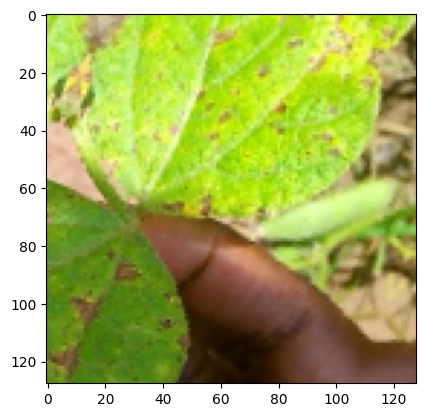

In [124]:
augment_model = Sequential([
keras.Input(shape=(300, 300, 3)),
layers.RandomCrop(128,128),
layers.RandomFlip(mode='horizontal'),
layers.RandomRotation(0.1)
    ])

model_with_aug = Sequential([
augment_model, 
Xception(input_shape=(128, 128, 3), include_top=False),
layers.GlobalMaxPool2D(),
layers.Dropout(0.5),
layers.Dense(3)
])

plt.imshow(augment_model(train_generator[0][0], training=True).numpy()[0]);

___
### <a id=30>Обучение моддели с ImageDataGenerator</a>

In [119]:
logs_path = 'logs/'
tensorboard_call = tf.keras.callbacks.TensorBoard(log_dir=logs_path)

- `steps_per_epoch`: количество шагов , которые будут выполнены в рамках одной эпохи обучения

In [ ]:
# model = Sequential([
#   Xception(input_shape=(128, 128, 3), include_top=False),
#   layers.GlobalMaxPool2D(),
#   layers.Dropout(0.5),
#   layers.Dense(3)
# ])
model_with_aug.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=['accuracy']
)
model_with_aug.fit(train_generator,
            steps_per_epoch=len(train_generator),
            epochs=20,
            callbacks=tensorboard_call)

In [126]:
%load_ext tensorboard

In [128]:
%tensorboard --logdir logs/

Reusing TensorBoard on port 6006 (pid 17193), started 0:00:10 ago. (Use '!kill 17193' to kill it.)